<a href="https://colab.research.google.com/github/malikbaqi12/Applied-data-science-using-pyspark-code-files/blob/main/data_cleaning_aggregation_and_bipartite_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

## Reading in the Data

In [31]:
df = pd.read_csv("DataCoSupplyChainDataset.csv", encoding_errors="ignore")

## Data Cleaning and Preparation

As the dataset has lots of columns we will remove redundant/duplicate information to make working with it more simple.

Replacing spaces in column names makes it so that we can call them easier

In [32]:
old_new_dict = {old_name:old_name.replace(" ", "_") for old_name in df.columns}
df_prep = df.rename(columns=old_new_dict)
df_prep.rename(columns={"shipping_date_(DateOrders)": "shipping_date"}, inplace=True)

#### Handling NaN values

In [33]:
significant_nan_cols = []
for i in df_prep.columns:
    
    if sum(df_prep[i].isna())/len(df_prep) > 0.05:
        print(i)
        significant_nan_cols.append(i)

Order_Zipcode
Product_Description


As we can see, all of the Product Descriptions and most of the Zipcodes are NaN values and will therefore be excluded. Interestingly, although the zip code is missing more than 85%, we can still work with the "Customer City" columns since it does not have any missing values. Also, we will exclude "Product Image" from the data as we will not need it.

In [34]:
sum(df_prep["Customer_City"].isna())

0

In [35]:
df_no_nan = df_prep.drop(columns=list(significant_nan_cols) + ["Product_Image"])

#### Handling Attributes w/o Variance

Checking for variance in the data, columns that don't have any variance (i.e. only one value) can also be excluded. As we can see, Customer Email and Password have been redacted (for obvious reasons). Therefore, we can also exclude them from the Dataset.

In [36]:
def check_variance(data, log=False):
    
    no_variance_cols = []
    for i in data.dtypes.index:
        number_unique = len(data[i].value_counts())
        if number_unique == 1:
            print(i, "Unique Value: {}".format(data[i].value_counts().index[0]))
            no_variance_cols.append(i)
        
    if log:
        return no_variance_cols, {"No variability in attribute(s):": no_variance_cols}
    else:            
        return no_variance_cols

no_variance_cols, variance_log = check_variance(df_no_nan, log=True)

Customer_Email Unique Value: XXXXXXXXX
Customer_Password Unique Value: XXXXXXXXX
Product_Status Unique Value: 0.0


In [37]:
df_var = df_no_nan.drop(columns=no_variance_cols)

In [38]:
print("Columns removed: {}".format(len(df.columns) - len(df_var.columns)))

Columns removed: 6


In total we removed 6 columns without losing any information while making the dataset more lean and easier to work with

In [39]:
one_order_id = df_var.loc[df_var["Order_Id"] == 48880]

As we can see, almost all columns are the same except for things such as Benefits per order and category id as these are specific to the product. These columns will be aggregated later on.

#### Customer Information

For this, we will summarize all the neccessary information about a customer, we will also drop some columns as they would not make sense.

In [40]:
# df_prep.groupby(["Customer Id"]).agg()
len(df_var.loc[df_var.Order_Customer_Id == df_var.Customer_Id])/len(df_var)

1.0

### Removing Redundancies

At this point, we can see that even the Order Customer Id and Customer Id are the same. It would make sense to make a function that check for all columns wether the values match to 100% to remove redundancies. Otherwiese one could opt to consult the makers of the dataset for further info

In [41]:
from itertools import combinations

def check_redundancies(data):
    
    redundancy_list = []
    
    for i in list(combinations(data.columns, 2)):
        
        if all(data[i[0]] == data[i[1]]):
            redundancy_list.append(i)
            print("{} and {} are the same".format(*i))
    
    return redundancy_list
                
redundancies = check_redundancies(df_var)

Benefit_per_order and Order_Profit_Per_Order are the same
Sales_per_customer and Order_Item_Total are the same
Category_Id and Product_Category_Id are the same
Customer_Id and Order_Customer_Id are the same
Order_Item_Cardprod_Id and Product_Card_Id are the same


Let's always remove the column witht the shortest name to make life even simpler

In [42]:
to_drop =[]
for i in redundancies:
    if len(i[0]) < len(i[1]):
        to_drop.append(i[1])
    else:
        to_drop.append(i[0])

In [43]:
df_clean = df_var.drop(columns=to_drop)

Because we will identify customers/departments by their CustomerId/DepartmentId there is no need for the Customer_Lname Customer_Fname and DepartmentId columns

In [44]:
df_clean.drop(columns=["Customer_Lname", "Customer_Fname", "Department_Name"], inplace=True)

In [45]:
df_clean["shipping_date"] = pd.to_datetime(df_clean["shipping_date"]) 

In [46]:
len(df_clean.columns) - len(df.columns)

-14

Summary:

- removed:
	- Zip Code, Product Descriptions -> almost only NaN
	- Product_Image -> no use for analysis
	- Product Category Id, Order_Item_Cardprod_Id, Order_Item_Product_Price_Order_Customer_Id, Benefit_per_order -> 100% overlap
	- Customer_Email, Customer_Password, Product_Status -> no variability in data
	- Customer_Lname, Customer_Fname, Department_Name -> no need for them as identifiers (already have Customer/Department Id)

## Data Warehousing

The goal is to facilitate the access to relevant data for the individuals of the company.

- The **Company management** might care about comparing different stores or categories. (maybe also within different time periods)
- The **different departments** (stores) want information relevant to their store, target market or customers

### Aggregating Department Information

We want to aggregate the information that is available about the different appartments to facilitate the decision making of the Management. Managers should also be able to see changes over time. Therefore we will add a functionality that lets the user split the specified time frame into sections to see changes in the metrics over time. (e.g. monthly increments)

In [47]:

def agg_dep(df, dep_id=None, timeframe=None, time_increments = None):
    
    # get the data from a specified department or from all departments.
    if dep_id:
        data = df.loc[df["Department_Id"].isin(dep_id)]
    else:
        data = df
    
    # get a specified time frame or, if not specified, data from the entire records.
    if timeframe:
        mask = (timeframe[0] < data["shipping_date"]) & (data["shipping_date"] < timeframe[1])
        data = data.loc[mask]
    
    group_cols = ["Department_Id"]    
    
    if time_increments == "Yearly":
        data["shipping_date_simple"] = data["shipping_date"].dt.strftime("%Y")
        
        group_cols += ["shipping_date_simple"]
    elif time_increments == "Monthly":
        data["shipping_date_simple"] = data["shipping_date"].dt.strftime("%Y%m")
        group_cols += ["shipping_date_simple"]
            
    return data.groupby(group_cols).agg(avg_price = ("Product_Price",np.average),
                                            total_profit = ("Benefit_per_order", "sum"),
                                            revenue = ("Sales", "sum"),
                                            total_discount = ("Order_Item_Discount","sum"),
                                            num_customers = ("Customer_Id", lambda x: len(x.unique())),   
                                            avg_scheduled_shipment_time = ("Days_for_shipment_(scheduled)", np.average),
                                            avg_shipment_time = ("Days_for_shipping_(real)", np.average),
                                            delivery_risk_fraction = ("Late_delivery_risk", np.average))

Without the dep_id this will get a less granular overview of the different departments and how they compare to one another.

In [48]:
dep_agg = agg_dep(df_clean, dep_id=[2], time_increments="Yearly")

<ipython-input-47-8c0ff3d6bf57>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["shipping_date_simple"] = data["shipping_date"].dt.strftime("%Y")


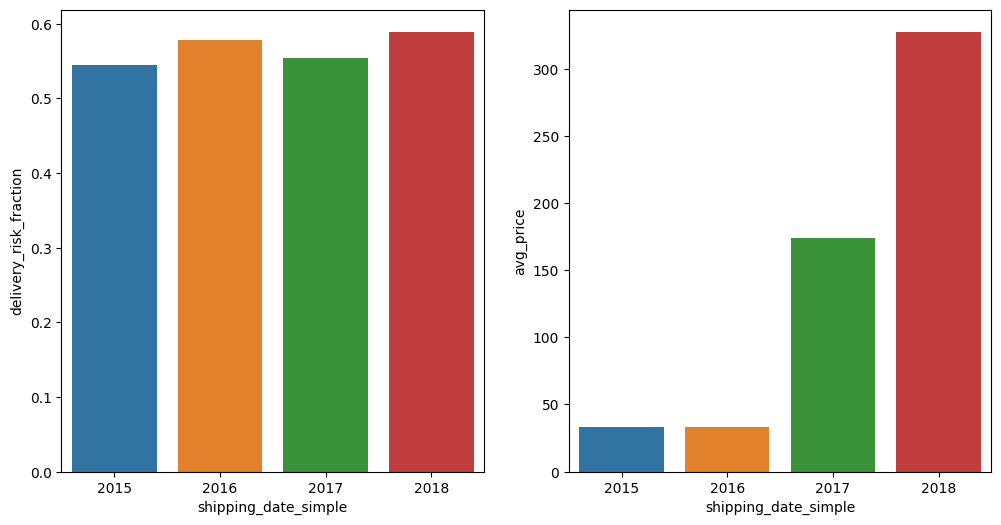

In [49]:
def summary(df, metrics):
    
    # initialize the figure
    fig, axs = plt.subplots(1,len(metrics), figsize=(12,6))
    fig.patch.set_facecolor('white')
    
    # plot the metrics on the axes
    for i,j in enumerate(metrics):
        sns.barplot(x=df.loc[2].index, y=j, data=df, ax=axs[i])
        
summary(dep_agg, ["delivery_risk_fraction", "avg_price"])

In [50]:
all_deps = agg_dep(df_clean)
all_deps["revenue_per_customer"] = all_deps["revenue"]/all_deps["num_customers"]
all_deps["avg_delay"] = all_deps["avg_shipment_time"] - all_deps["avg_scheduled_shipment_time"]

<Axes: xlabel='avg_delay', ylabel='revenue_per_customer'>

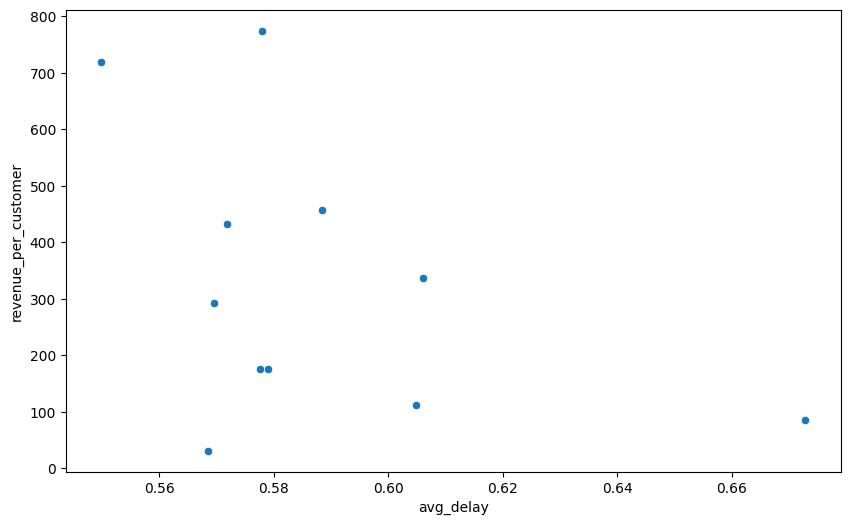

In [51]:
fig, axs = plt.subplots(1,1, figsize=(10,6))
fig.patch.set_facecolor('white')
sns.scatterplot(x="avg_delay", y="revenue_per_customer", data=all_deps)

## Mapping Supply Chain as a Bipartite Graph.

We can also map the supply chain as a bipartite graph where one node set represents the department stores and the other one customers (Customer Regions to be more specific.)

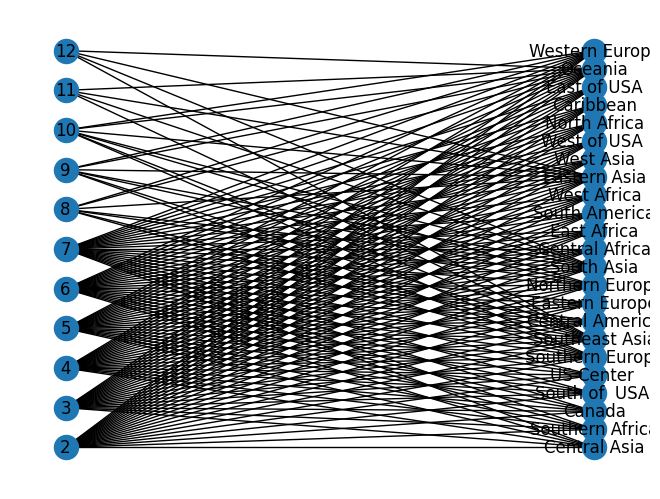

In [52]:
def show_bipartite(df, dep_id=None):
    g = nx.Graph()
    
    if dep_id:
        df = df.loc[df["Department_Id"].isin(dep_id)]
        
    departments = df.Department_Id.unique()

    for department in departments:
        g.add_node(department)
        
        dep_info = df.loc[df["Department_Id"] == department, ["Sales", "Order_Region"]]
        dep_sales = np.sum(dep_info).Sales
        dep_regions = dep_info.groupby(["Order_Region"]).agg("sum")
        
        g.add_edges_from([(department, i) for i in dep_regions.index])
        g.add_nodes_from(dep_regions.index)

    nx.draw(g, with_labels=True, pos=nx.bipartite_layout(g, departments))
    return g
    
    
g = show_bipartite(df_clean)

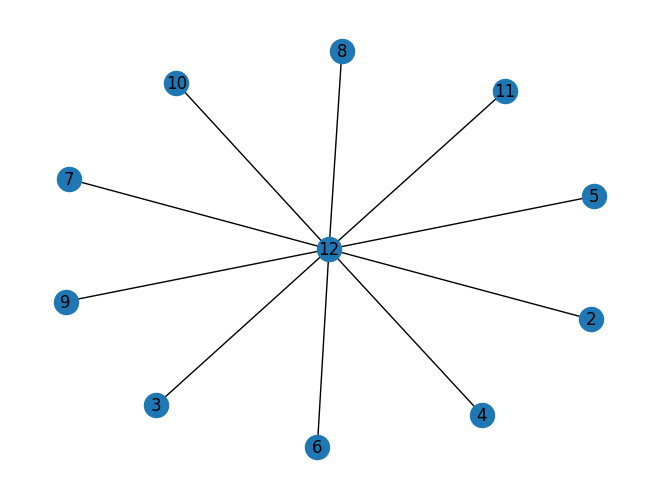

In [53]:
# 2 nodes will be connected if they have a common neighbor in the other node set.
projected = nx.bipartite.projected_graph(g, [12])
nx.draw(projected, with_labels=True)

Note that because we have selected all the years and even one sale made to the region counts as a connection, almost all departments have connections with almost all of the regions. We could of course adjust this by changing the timeframe or only considering departments as connected with regions once they reach a specific threshold (e.g. percentage of total sales).

In [54]:
df_clean.head(3)
df_clean.select_dtypes("object").head(3)

,Type,Delivery_Status,Category_Name,Customer_City,Customer_Country,Customer_Segment,Customer_State,Customer_Street,Market,Order_City,Order_Country,order_date_(DateOrders),Order_Region,Order_State,Order_Status,Product_Name,Shipping_Mode
0,DEBIT,Advance shipping,Sporting Goods,Caguas,Puerto Rico,Consumer,PR,5365 Noble Nectar Island,Pacific Asia,Bekasi,Indonesia,1/31/2018 22:56,Southeast Asia,Java Occidental,COMPLETE,Smart watch,Standard Class
1,TRANSFER,Late delivery,Sporting Goods,Caguas,Puerto Rico,Consumer,PR,2679 Rustic Loop,Pacific Asia,Bikaner,India,1/13/2018 12:27,South Asia,Rajastn,PENDING,Smart watch,Standard Class
2,CASH,Shipping on time,Sporting Goods,San Jose,EE. UU.,Consumer,CA,8510 Round Bear Gate,Pacific Asia,Bikaner,India,1/13/2018 12:06,South Asia,Rajastn,CLOSED,Smart watch,Standard Class


In [55]:
# get information about the customers
def agg_cust(df, dep_id=None, timeframe=None, time_increments = None):
    
    # get the data from a specified department or from all departments.
    if dep_id:
        df = df.loc[df["Department_Id"].isin(dep_id)]
    
    # get a specified time frame or, if not specified, data from the entire records.
    if timeframe:
        mask = (timeframe[0] < df["shipping_date"]) & (df["shipping_date"] < timeframe[1])
        data = data.loc[mask]
    
    group_cols = ["Customer_Id"]    
    
    # if time_increments == "Yearly":
    #     df["shipping_date_simple"] = df["shipping_date"].dt.strftime("%Y")
    #     
    #     group_cols += ["shipping_date_simple"]
    # elif time_increments == "Monthly":
    #     df["shipping_date_simple"] = df["shipping_date"].dt.strftime("%Y%m")
    #     group_cols += ["shipping_date_simple"]
    
    cust_meta = df[["Customer_City", "Customer_Country", "Customer_Segment", "Market", "Shipping_Mode", "Customer_Id"]]
           
    max_date = max(df.shipping_date)
            
    agg_data = df.groupby(group_cols).agg(avg_price = ("Product_Price",np.average),
                                            total_profit = ("Benefit_per_order", "sum"),
                                            revenue = ("Sales", "sum"),
                                            total_discount = ("Order_Item_Discount","sum"),
                                            avg_scheduled_shipment_time = ("Days_for_shipment_(scheduled)", np.average),
                                            avg_shipment_time = ("Days_for_shipping_(real)", np.average),
                                            delivery_risk_fraction = ("Late_delivery_risk", np.average),
                                            relation_duration = ("shipping_date", lambda x: max(x) - min(x)),
                                            num_orders = ("Order_Id", lambda x: len(x.unique())),
                                            recency = ("shipping_date", lambda x: max_date - max(x)))
    
    
    return agg_data.join(cust_meta, on="Customer_Id", how="left").drop(columns=["Customer_Id"])

In [56]:
cust_data = agg_cust(df_clean)
cust_data.head(3)

,avg_price,total_profit,revenue,total_discount,avg_scheduled_shipment_time,avg_shipment_time,delivery_risk_fraction,relation_duration,num_orders,recency,Customer_City,Customer_Country,Customer_Segment,Market,Shipping_Mode
Customer_Id,,,,,,,,,,,,,,,
1,99.989998,159.690002,499.950012,27.50,4.000000,6.000000,1.000000,0 days 00:00:00,1,791 days 20:26:00,Caguas,Puerto Rico,Consumer,Pacific Asia,Standard Class
2,127.130003,296.579996,1199.810020,116.48,4.000000,4.857143,0.428571,349 days 18:36:00,2,282 days 16:04:00,San Jose,EE. UU.,Consumer,Pacific Asia,Standard Class
3,96.848573,-52.719998,777.920008,63.14,2.285714,1.857143,0.000000,549 days 03:52:00,4,235 days 05:22:00,Los Angeles,EE. UU.,Home Office,Pacific Asia,Standard Class


<Axes: xlabel='recency', ylabel='Count'>

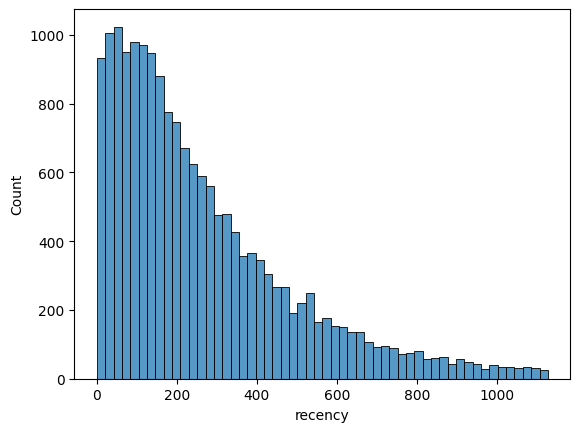

In [57]:
sns.histplot(cust_data.recency.dt.days)

<Axes: xlabel='revenue', ylabel='Count'>

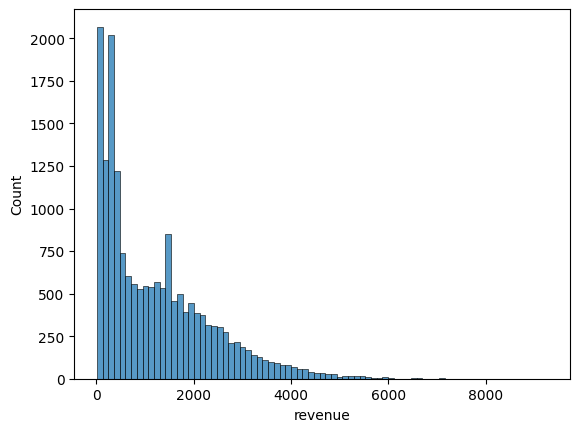

In [58]:
sns.histplot(data=cust_data, x="revenue")